# Sparta 2: Rigorous ML Pipeline for Commodity Prediction

**Objective**: Predict `Com_LME_Ni_Cash` (Nickel) returns using a strict machine learning workflow.
**Workflow**:
1.  **EDA**: Visual inspection and statistical summary.
2.  **Preprocessing**: Time-series alignment, missing value handling.
3.  **Feature Engineering**: 
    -   Domain Filtering (Metals & Economic Indicators only).
    -   Derivation (Log Returns, Differences).
    -   Selection (SHAP values via XGBoost).
4.  **Modeling**: Implementation of 4 Boosting Algorithms (XGBoost, LightGBM, CatBoost, GradientBoosting).
5.  **Evaluation**: Comparative analysis using 5 key metrics (RMSE, MAPE, MAE, R2, Adj R2).

In [13]:
# 0. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Plotting Style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries loaded successfully. Proceeding with discipline.")

Libraries loaded successfully. Proceeding with discipline.


## 1. Exploratory Data Analysis (EDA)
We begin by understanding the raw data structure, checking for anomalies, and visualizing the target variable's behavior.

Data Shape: (668, 74)
Time Range: 2013-04-01 00:00:00 to 2026-01-12 00:00:00


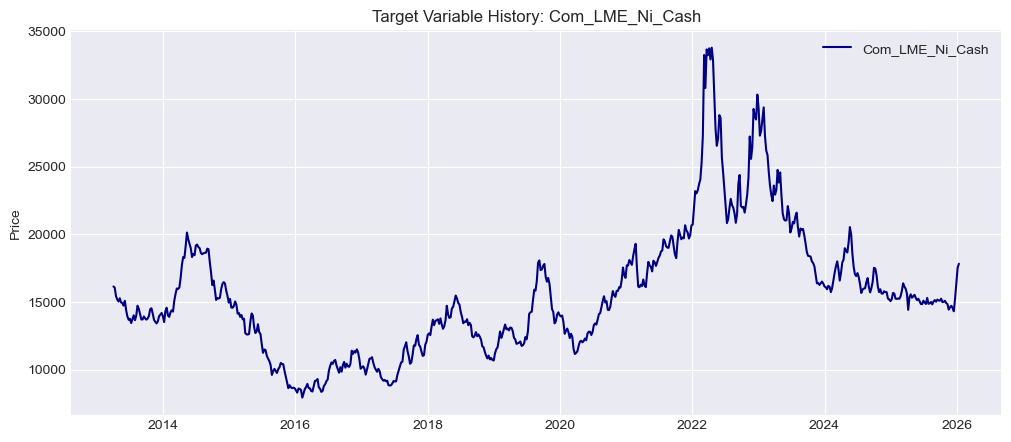


Descriptive Statistics (Key Metals):


,Com_LME_Ni_Cash,Com_LME_Cu_Cash,Com_LME_Al_Cash,Com_LME_Pb_Cash,Com_LME_Sn_Cash,Com_LME_Zn_Cash
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,15521.658782,7325.798141,2084.675374,2057.015681,23808.332859,2590.496756
std,4760.673476,1724.633587,418.306229,206.536437,7226.272019,534.628307
min,7925.000000,4362.700000,1432.500000,1587.600000,13404.000000,1467.200000
25%,12340.875000,5918.175000,1760.250000,1936.475000,19007.250000,2198.825000
50%,14957.400000,6959.850000,2007.162500,2049.537500,21276.600000,2589.475000
75%,17804.750000,8888.375000,2359.825000,2169.475000,28084.850000,2949.112500
max,33781.250000,13232.000000,3626.000000,2648.100000,50460.000000,4510.000000


In [14]:
# Load Data
filename = 'data_weekly_260120.csv'
df = pd.read_csv(filename)
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt').sort_index()

print(f"Data Shape: {df.shape}")
print(f"Time Range: {df.index.min()} to {df.index.max()}")

# Target Definition
target_base = 'Com_LME_Ni_Cash'

# Visualization 1: Target Price History
plt.figure(figsize=(12, 5))
plt.plot(df.index, df[target_base], label=target_base, color='navy')
plt.title(f'Target Variable History: {target_base}')
plt.ylabel('Price')
plt.legend()
plt.show()

# Descriptive Statistics
print("\nDescriptive Statistics (Key Metals):")
metal_cols = [c for c in df.columns if 'Com_LME' in c and 'Cash' in c]
display(df[metal_cols].describe())

## 2. Preprocessing
**Plan**:
1.  **Missing Values**: Financial time series data is continuous. We use **Forward Fill (ffill)** to propagate last known valid observations.
2.  **Date Gaps**: Verify weekly frequency consistency.

In [15]:
# Missing Values
if df.isnull().sum().sum() > 0:
    print(f"Missing values detected: {df.isnull().sum().sum()}")
    print("Applying Forward Fill (ffill)...")
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill') # Fallback for initial rows
else:
    print("Data is clean. No missing values found.")

# Frequency Check
freq_check = df.index.to_series().diff().dt.days.value_counts()
print("\nTime Frequency Distribution (Days):")
print(freq_check)

if freq_check.index[0] != 7:
    print("WARNING: Data is not strictly weekly. Consider resampling if necessary.")
else:
    print("Data confirmed as Weekly.")

Data is clean. No missing values found.

Time Frequency Distribution (Days):
dt
7.0    667
Name: count, dtype: int64
Data confirmed as Weekly.


## 3. Feature Engineering & Selection
**Strict Rules**:
1.  **Filter**: Only include features related to **Metals** (`Com_...`) and **Economic Indicators** (`Idx_`, `Bonds_`, `EX_`). Food/Agri commodities are excluded.
2.  **Derivation**: Calculate Log Returns and First Differences (Diff) to ensure stationarity.
3.  **Selection**: Use SHAP values from a tuning-free XGBoost model to select the top predictors.

In [16]:
# 1. Filter Columns
def is_relevant_feature(col_name):
    # Keep Economic Indicators
    if any(x in col_name for x in ['Idx_', 'Bonds_', 'EX_']):
        return True
    # Keep Specific Metals
    if 'Com_' in col_name:
        metals = ['LME', 'Gold', 'Silver', 'Iron', 'Steel', 'Copper', 'Aluminum', 'Zinc', 'Nickel', 'Lead', 'Tin', 'Uranium']
        if any(m in col_name for m in metals):
            return True
    return False

relevant_cols = [c for c in df.columns if is_relevant_feature(c)]
print(f"Feature filtering: {len(df.columns)} -> {len(relevant_cols)} columns.")
df_filtered = df[relevant_cols].copy()

# 2. Derive Features
df_eng = pd.DataFrame(index=df_filtered.index)
for col in df_filtered.columns:
    # Log Return: ln(P_t / P_t-1)
    try:
        df_eng[f'{col}_log_ret'] = np.log(df_filtered[col] / df_filtered[col].shift(1))
    except:
        pass
    # Diff: P_t - P_t-1
    df_eng[f'{col}_diff'] = df_filtered[col].diff()

# Drop NaNs from differencing
df_eng.dropna(inplace=True)

# Define Target (Nickel Log Returns)
target_col = f'{target_base}_log_ret'
if target_col not in df_eng.columns:
    raise ValueError(f"Target {target_col} creation failed!")

# Prepare X, y
X_all = df_eng.drop(columns=[target_col])
# Drop leakage columns (versions of target)
leakage_cols = [c for c in X_all.columns if target_base in c]
X_all = X_all.drop(columns=leakage_cols)
y_all = df_eng[target_col]

print(f"Engineered Feature Set: {X_all.shape}")

Feature filtering: 74 -> 52 columns.
Engineered Feature Set: (665, 102)


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/kw/2yp1vxc13j598z_jr_jghrz80000gn/T/ipykernel_19928/1145173251.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[f'{col}_log_ret'] = np.log(df_filtered[col] / df_filtered[col].shift(1))
/var/folders/kw/2yp1vxc13j598z_jr_jghrz80000gn/T/ipykernel_19928/1145173251.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[f'{co

Training XGBoost for SHAP selection...

Top 20 Selected Features by SHAP:


,feature,importance
90,Com_LME_Index_log_ret,0.011582
91,Com_LME_Index_diff,0.004234
5,Com_LME_Pb_Cash_diff,0.002129
0,Com_LME_Cu_Cash_log_ret,0.001502
100,Com_Silver_log_ret,0.001471
94,Com_Iron_Ore_log_ret,0.001462
6,Com_LME_Sn_Cash_log_ret,0.001298
11,Com_LME_Ni_Inv_diff,0.001189
81,Bonds_IND_10Y_diff,0.001143
15,Com_LME_Al_Inv_diff,0.001063


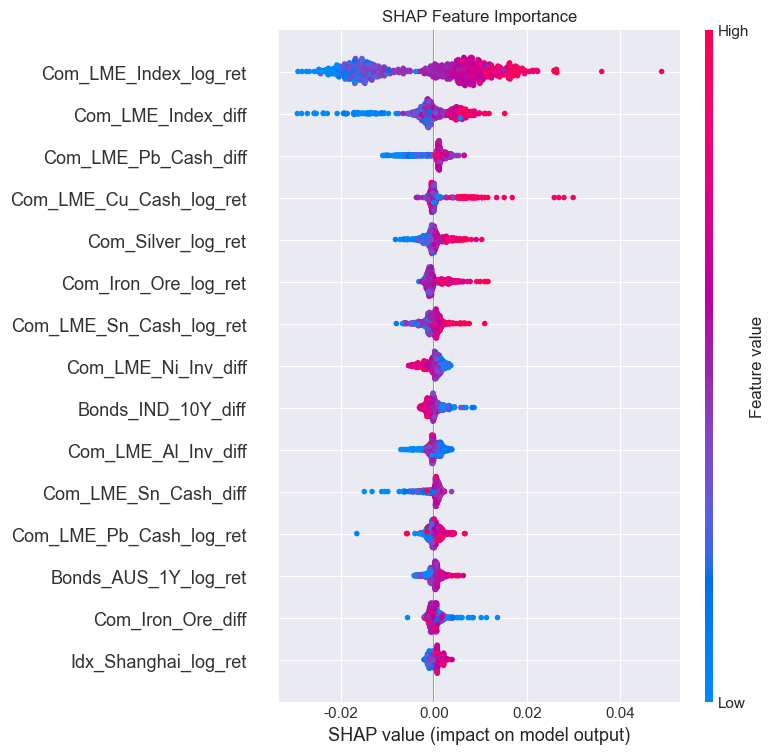

In [17]:
# 3. SHAP Feature Selection
print("Training XGBoost for SHAP selection...")
model_shap = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
model_shap.fit(X_all, y_all)

# Compute SHAP
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_all)

# Feature Importance
mean_shap = np.abs(shap_values).mean(axis=0)
fi_df = pd.DataFrame({'feature': X_all.columns, 'importance': mean_shap})
fi_df = fi_df.sort_values('importance', ascending=False)

# Select Top N (e.g., Top 20 for parsimony)
top_n = 20
selected_features = fi_df.head(top_n)['feature'].tolist()

print(f"\nTop {top_n} Selected Features by SHAP:")
display(fi_df.head(10))

# Plot SHAP Summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_all, max_display=15, show=False)
plt.title("SHAP Feature Importance")
plt.show()

# Finalize X
X_final = X_all[selected_features]

## 4. Modeling (The 'Big 4')
We apply four robust gradient boosting algorithms:
1.  **XGBoost**
2.  **LightGBM**
3.  **CatBoost**
4.  **GradientBoosting (sklearn)**

**Validation Strategy**: Time-Series Split (Last 20% as Test). **NO SHUFFLING**.

In [18]:
# Train/Test Split (Strict Time Series)
split_idx = int(len(X_final) * 0.8)
X_train, X_test = X_final.iloc[:split_idx], X_final.iloc[split_idx:]
y_train, y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]

print(f"Train Period: {X_train.index.min()} to {X_train.index.max()} (n={len(X_train)})")
print(f"Test Period : {X_test.index.min()} to {X_test.index.max()} (n={len(X_test)})")

# Dictionary to store models and results
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=500, learning_rate=0.05, random_state=42, verbose=0, allow_writing_files=False),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
}

results = []
preds = pd.DataFrame(index=y_test.index)
preds['Actual'] = y_test

print("\nStarting Model Training...")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adj R2
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae,
        'R2': r2,
        'Adj_R2': adj_r2
    })

print("Training Complete.")

Train Period: 2013-04-08 00:00:00 to 2023-06-26 00:00:00 (n=532)
Test Period : 2023-07-03 00:00:00 to 2026-01-12 00:00:00 (n=133)

Starting Model Training...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Training GradientBoosting...
Training Complete.


## 5. Performance Evaluation
Comparison of model performance across 5 key metrics.

,RMSE,MAPE,MAE,R2,Adj_R2
Model,,,,,
XGBoost,0.0267,3.7608,0.0211,-0.0084,-0.1884
LightGBM,0.0275,4.1924,0.0214,-0.0735,-0.2652
CatBoost,0.0240,3.1540,0.0184,0.1851,0.0395
GradientBoosting,0.0256,3.1694,0.0193,0.0674,-0.0991



Best Model by RMSE: CatBoost


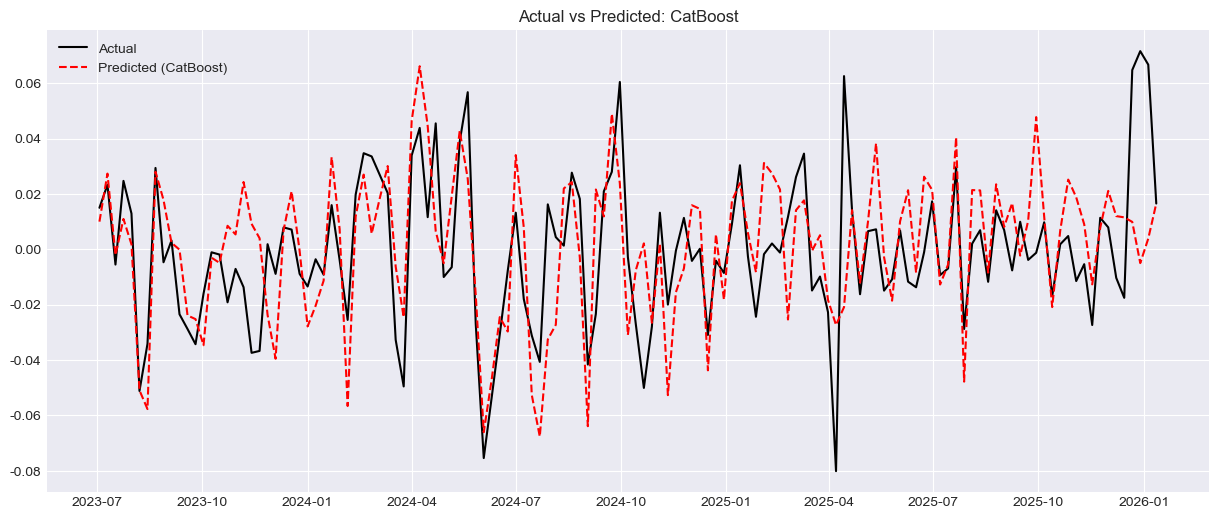

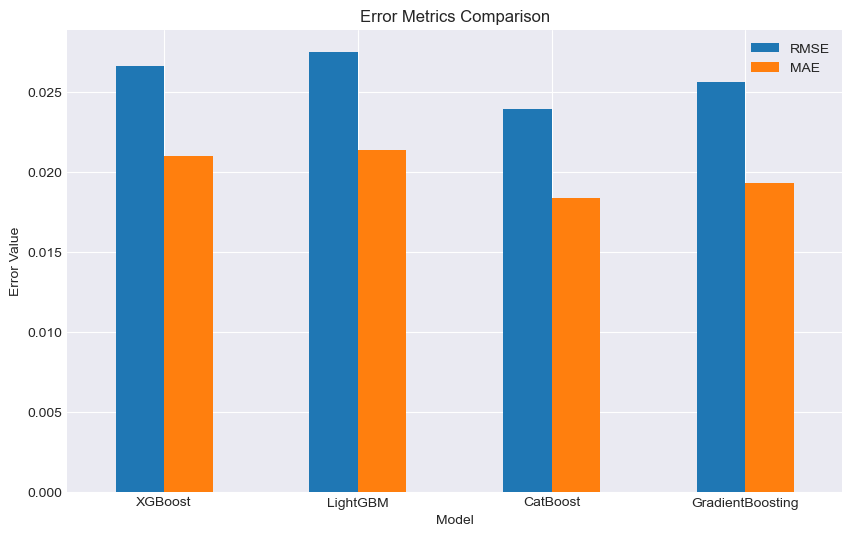

In [19]:
# Results Table
results_df = pd.DataFrame(results).set_index('Model')
display(results_df.style.background_gradient(cmap='viridis', subset=['R2', 'Adj_R2']).format("{:.4f}"))

# Visualization: Actual vs Predicted (Best Model)
best_model_name = results_df['RMSE'].idxmin()
print(f"\nBest Model by RMSE: {best_model_name}")

plt.figure(figsize=(15, 6))
plt.plot(preds.index, preds['Actual'], label='Actual', color='black', linewidth=1.5)
plt.plot(preds.index, preds[best_model_name], label=f'Predicted ({best_model_name})', color='red', linestyle='--')
plt.title(f'Actual vs Predicted: {best_model_name}')
plt.legend()
plt.show()

# Visualization: Model Comparison
results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6))
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.xticks(rotation=0)
plt.show()